<a href="https://colab.research.google.com/github/KAKUMA-Minato/TextAnalysis/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 必要なライブラリ・データセットのインポート

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import collections
from nltk import cluster
from nltk.cluster import euclidean_distance
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.decomposition as skd

### 今回は以下のnltkの機能を使用できる様にする


In [79]:
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("reuters")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### データを取得

In [80]:
from nltk.corpus import reuters as corpus

### datasetの中身を確認

In [81]:
for n,item in enumerate(corpus.words(corpus.fileids()[0])[:300]):
    print(item, end=" ")
    if (n%25) ==24:
      print(" ")

ASIAN EXPORTERS FEAR DAMAGE FROM U . S .- JAPAN RIFT Mounting trade friction between the U . S . And Japan has raised fears  
among many of Asia ' s exporting nations that the row could inflict far - reaching economic damage , businessmen and officials said . They  
told Reuter correspondents in Asian capitals a U . S . Move against Japan might boost protectionist sentiment in the U . S . And  
lead to curbs on American imports of their products . But some exporters said that while the conflict would hurt them in the long -  
run , in the short - term Tokyo ' s loss might be their gain . The U . S . Has said it will  
impose 300 mln dlrs of tariffs on imports of Japanese electronics goods on April 17 , in retaliation for Japan ' s alleged failure to  
stick to a pact not to sell semiconductors on world markets at below cost . Unofficial Japanese estimates put the impact of the tariffs at  
10 billion dlrs and spokesmen for major electronics firms said they would virtually halt exports 

### 全document数

In [82]:
len(corpus.fileids())

10788

### 前から1000個のdocumentのみで学習する

In [83]:
k = 1000
docs=[corpus.words(fileid) for fileid in corpus.fileids()[:k]]

## 前処理編

### 例 : ストップワードリストの作成

### nltkのストップワードリスト

In [84]:
en_stop = nltk.corpus.stopwords.words('english')

### 例:【発展】記号や数字は正規表現で消してみる

In [85]:
en_stop= ["``","/",",.",".,",";","--",":",")","(",'"','&',"'",'),',',"','-','.,','.,"','.-',"?",">","<"]                  \
         +["0","1","2","3","4","5","6","7","8","9","10","11","12","86","1986","1987","000"]                                                      \
         +["said","say","u","v","mln","ct","net","dlrs","tonne","pct","shr","nil","company","lt","share","year","billion","price"]          \
         +en_stop

### 前処理関数の作成

In [86]:
from nltk.corpus import wordnet as wn #lemmatize関数のためのimport

def preprocess_word(word, stopwordset):
    
    #1.make words lower ex: Python =>python
    word=word.lower()
    
    #2.remove "," and "."
    if word in [",","."]:
        return None
    
    #3.remove stopword  ex: the => (None) 
    if word in stopwordset:
        return None
    
    #4.lemmatize  ex: cooked=>cook
    lemma = wn.morphy(word)
    if lemma is None:
        return word

    elif lemma in stopwordset: #lemmatizeしたものがstopwordである可能性がある
        return None
    else:
        return lemma
    

def preprocess_document(document):
    document=[preprocess_word(w, en_stop) for w in document]
    document=[w for w in document if w is not None]
    return document

def preprocess_documents(documents):
    return [preprocess_document(document) for document in documents]

### 前処理の結果を出力してみる

### 前処理前

In [87]:
print(docs[0][:25]) 

['ASIAN', 'EXPORTERS', 'FEAR', 'DAMAGE', 'FROM', 'U', '.', 'S', '.-', 'JAPAN', 'RIFT', 'Mounting', 'trade', 'friction', 'between', 'the', 'U', '.', 'S', '.', 'And', 'Japan', 'has', 'raised', 'fears']


### 前処理後

In [88]:
print(preprocess_documents(docs)[0][:25])

['asian', 'exporter', 'fear', 'damage', 'japan', 'rift', 'mounting', 'trade', 'friction', 'japan', 'raise', 'fear', 'among', 'many', 'asia', 'exporting', 'nation', 'row', 'could', 'inflict', 'far', 'reaching', 'economic', 'damage', 'businessmen']


## クラスタリング編

### tf idfで上記の前処理済みの文章をベクトル化
### vectorizerを使用する（ハイパーパラメーターの設定）

In [89]:
pre_docs=preprocess_documents(docs)
pre_docs=[" ".join(doc) for doc in pre_docs]
print(pre_docs[0])

vectorizer = TfidfVectorizer(max_features=200, token_pattern=u'(?u)\\b\\w+\\b' )

asian exporter fear damage japan rift mounting trade friction japan raise fear among many asia exporting nation row could inflict far reaching economic damage businessmen official tell reuter correspondent asian capital move japan might boost protectionist sentiment lead curb american import product exporter conflict would hurt long run short term tokyo loss might gain impose 300 tariff import japanese electronics good april 17 retaliation japan allege failure stick pact sell semiconductor world market cost unofficial japanese estimate put impact tariff spokesman major electronics firm would virtually halt export product hit new tax able business spokesman leading japanese electronics firm matsushita electric industrial co ltd mc >. tariff remain place length time beyond month mean complete erosion export good subject tariff tom murtha stock analyst tokyo office broker james capel co >. taiwan businessmen official also worry aware seriousness threat japan serve warning us senior taiwan

### fitする

In [90]:
tf_idf = vectorizer.fit_transform(pre_docs)

### K-means
### kmeansの設定

In [135]:
#クラスタ数 / the number of clusters
n_clusters= 8

In [136]:
km = KMeans(n_clusters, random_state = 0)

### fitする

In [137]:
clusters = km.fit_predict(tf_idf)

### 出力結果

In [138]:
for doc, cls in zip(pre_docs, clusters):
    print(cls,doc)

3 asian exporter fear damage japan rift mounting trade friction japan raise fear among many asia exporting nation row could inflict far reaching economic damage businessmen official tell reuter correspondent asian capital move japan might boost protectionist sentiment lead curb american import product exporter conflict would hurt long run short term tokyo loss might gain impose 300 tariff import japanese electronics good april 17 retaliation japan allege failure stick pact sell semiconductor world market cost unofficial japanese estimate put impact tariff spokesman major electronics firm would virtually halt export product hit new tax able business spokesman leading japanese electronics firm matsushita electric industrial co ltd mc >. tariff remain place length time beyond month mean complete erosion export good subject tariff tom murtha stock analyst tokyo office broker james capel co >. taiwan businessmen official also worry aware seriousness threat japan serve warning us senior taiw

##可視化

In [139]:
trsvd = skd.TruncatedSVD(n_components=2)
transformed = trsvd.fit_transform(tf_idf)
VT = trsvd.components_

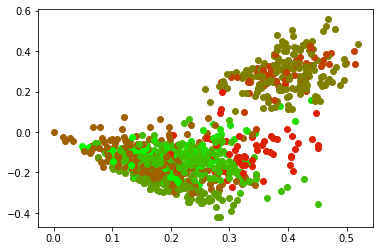

In [140]:
for i in range(999):
   col=(km.labels_[i])/n_clusters
   plt.scatter(transformed[i,0], transformed[i,1], color = [col, 1-col, 0.0])

###エルボー図

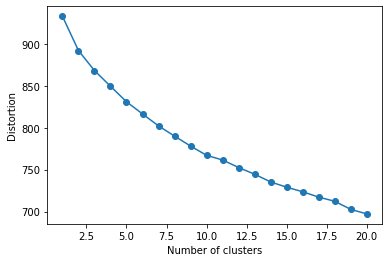

In [97]:
distortions = []

for i  in range(1,21):                # 1~20クラスタまで一気に計算 
    km = KMeans(n_clusters = i, random_state = 0)
    km.fit_predict(tf_idf)                        # クラスタリングの計算を実行
    distortions.append(km.inertia_)   # km.fitするとkm.inertia_が得られる

plt.plot(range(1,21),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()